In [1]:
from __future__ import absolute_import

from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt

from src.voronoi import VoronoiPolygons 

%config IPCompleter.greedy=True

## 1. Creating Voronoi polygons

```
vor.points - punkty wejściowe
vor.vertices - wierzchołki obszarów
    remark: niektóre wierzchołki leżą poza tym obszarem [0,1]^2, no bo część obszarów za niego wychodzi
vor.regions - dla każdego regionu podane są indeksy wierzchołków, które tworzą ten region. -1 oznacza brak wierzchołka (byłby tak wywalony w kosmos, że jest pomijany chyba)
vor.point_region - dla każdego punktu podany jest jaki region początkowy mu odpowiada
```

In [2]:
voronoi_polygons = VoronoiPolygons(N=25)

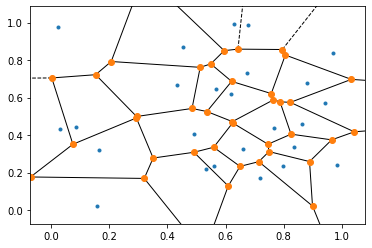

In [3]:
voronoi_plot_2d(voronoi_polygons.vor)
plt.show()

## 2. Replacing each point by the centroid of the region related to this point

Each region is convex, so the centroid is always inside the region. We're skipping regions on the edge of the grid. <br>
It's hard to compute centroid for them, we don't know about the vertices outside the grid.

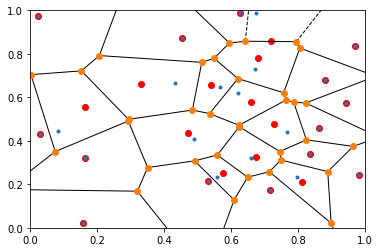

In [4]:
voronoi_plot_2d(voronoi_polygons.vor)
plt.scatter(voronoi_polygons.centroids[:,0], voronoi_polygons.centroids[:,1], c='red')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

## 3. Re-generating Voronoi regions using new points (centroids)

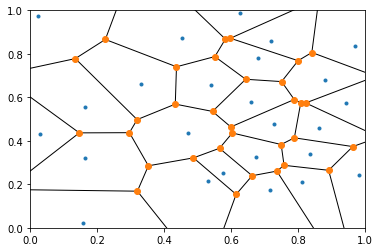

In [5]:
voronoi_plot_2d(voronoi_polygons.vor_c)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

## 4. Converting infitite vertices to finite ones

Then replacing vertices outside $[0,1]^2$ region by the intersection points.

In [6]:
new_regions, new_vertices, new_centroids = VoronoiPolygons.find_new_polygons(
    vor=voronoi_polygons.vor
)

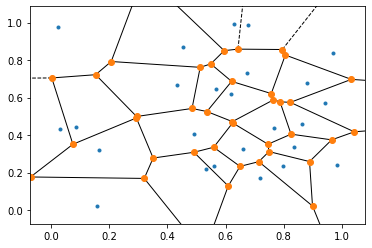

In [7]:
voronoi_plot_2d(voronoi_polygons.vor)
plt.show()

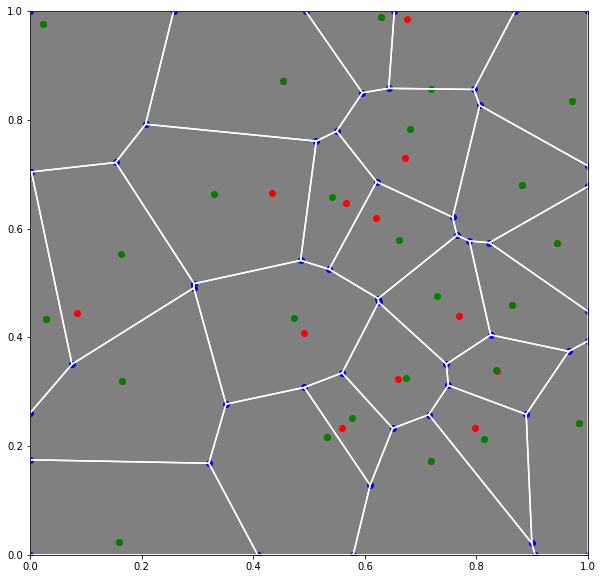

In [8]:
plt.figure(figsize=(10, 10))
plt.rcParams['axes.facecolor'] = 'grey'

for region in new_regions:
    region.append(region[0])
    coords = new_vertices[region]
    plt.plot(coords[:, 0], coords[:, 1],c='white')

plt.scatter(voronoi_polygons.points[:, 0], voronoi_polygons.points[:, 1], c='red')
plt.scatter(new_vertices[:, 0], new_vertices[:, 1], c='blue')
plt.scatter(voronoi_polygons.centroids[:, 0], voronoi_polygons.centroids[:, 1], c='green')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

## 5. Generate neighbours

In [9]:
neighbors, intersecions =  VoronoiPolygons.generate_neighbours(
    vor=voronoi_polygons.vor,
    regions=new_regions,
    vertices=new_vertices,
)

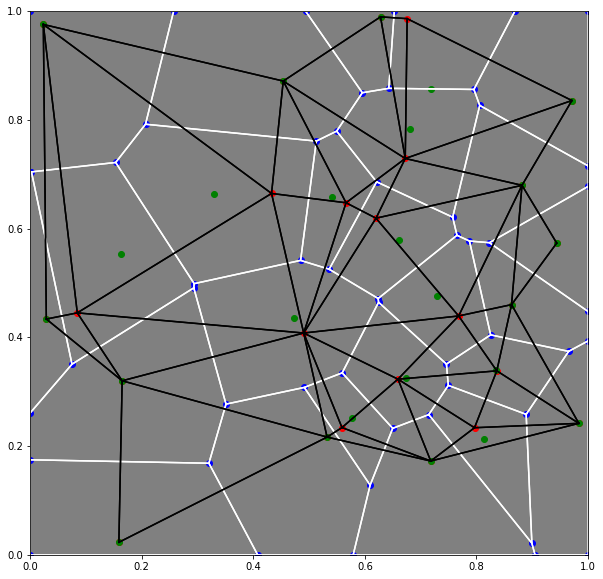

In [10]:
plt.figure(figsize=(10,10))
plt.rcParams['axes.facecolor'] = 'grey'

for region in new_regions:
    region.append(region[0])
    coords = new_vertices[region]
    plt.plot(coords[:, 0], coords[:, 1],c='white')
    
for i,n_list in enumerate(neighbors):
    p1 = voronoi_polygons.points[i]
    for i2 in n_list:
        p2 = voronoi_polygons.points[i2]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], c='black')
        
plt.scatter(voronoi_polygons.points[:, 0], voronoi_polygons.points[:, 1], c='red')
plt.scatter(new_vertices[:, 0], new_vertices[:, 1], c='blue')
plt.scatter(voronoi_polygons.centroids[:, 0], voronoi_polygons.centroids[:, 1], c='green')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

## 6. All previous steps together

In [11]:
vorpoints, points, new_vertices, new_regions, neighbors, intersecions \
    = voronoi_polygons.generate_Voronoi(iterations=2)

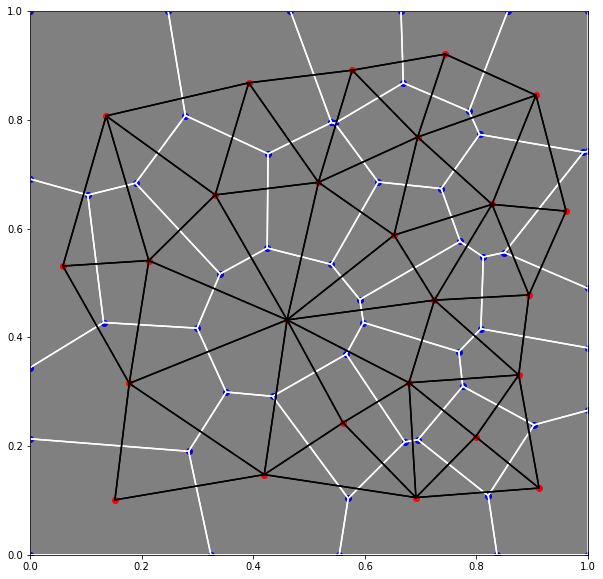

In [12]:
VoronoiPolygons.plot_Voronoi_grid(
    points=voronoi_polygons.points, vertices=new_vertices, regions=new_regions, neighbors=neighbors
)

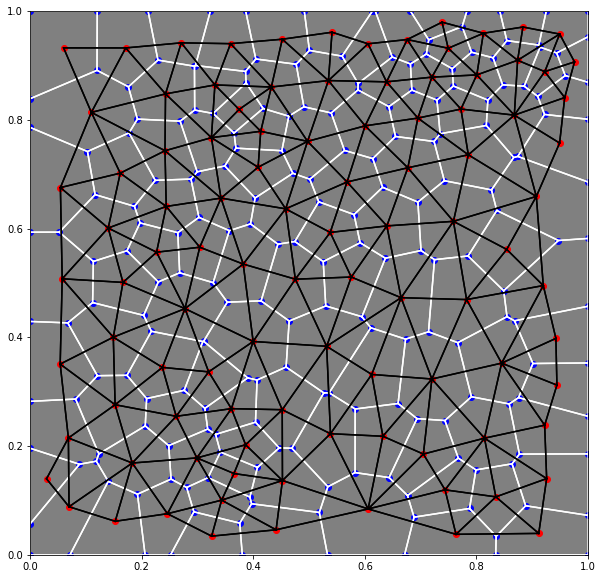

In [13]:
voronoi_polygons = VoronoiPolygons(N=100)

vorpoints, points, new_vertices, new_regions, neighbors, intersecions \
    = voronoi_polygons.generate_Voronoi(iterations=2)

VoronoiPolygons.plot_Voronoi_grid(
    points=voronoi_polygons.points, vertices=new_vertices, regions=new_regions, neighbors=neighbors
)

## 7. Map representation

TODO

Chyba już rozumiem zamysł tego, on ma 3 klasy:

* punkty (te w środku, czerwone), nazywane środkami
* wierzchołki
* krawędzie

I jest taka zależność, że jeśli 2 obszary graniczą ze sobą, to mają dokładnie 1 linię wspólną. Więc krawędź łączy ze sobą 2 graniczące środki ORAZ 2 wierzchołki, które tworzą granicę pomiędzy tymi polami.

To daje więcej możliwości poruszania po tym grafie, do tego on ma następujące metody:

* Center.neighbors is a set of adjacent polygons
* Center.borders is a set of bordering edges
* Center.corners is a set of polygon corners
* Edge.d0 and Edge.d1 are the polygons connected by the Delaunay edge
* Edge.v0 and Edge.v1 are the corners connected by the Voronoi edge
* Corner.touches is a set of polygons touching this corner
* Corner.protrudes is a set of edges touching the corner
* Corner.adjacent is a set of corners connected to this one

In [14]:
from src.map import Graph

In [15]:
%%time
g = Graph(N=250, iterations=2)

Wall time: 7.69 s


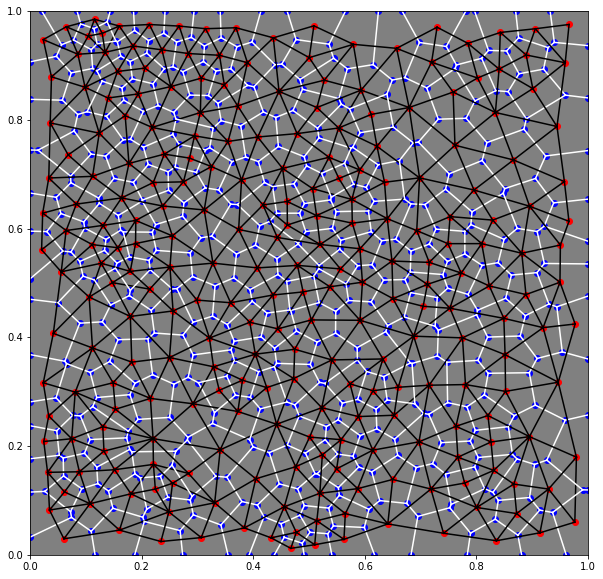

Wall time: 2.33 s


In [16]:
%%time
g.plot_map()

## 8. Terrain split and plotting
Plotowanie narożników ssie ale nie chciało mi się z tym bawić bo to narazie mało istotne

In [17]:
from src.terrain import assign_terrain_types_to_graph

In [18]:
assign_terrain_types_to_graph(graph=g, min_water_ratio=0.25)

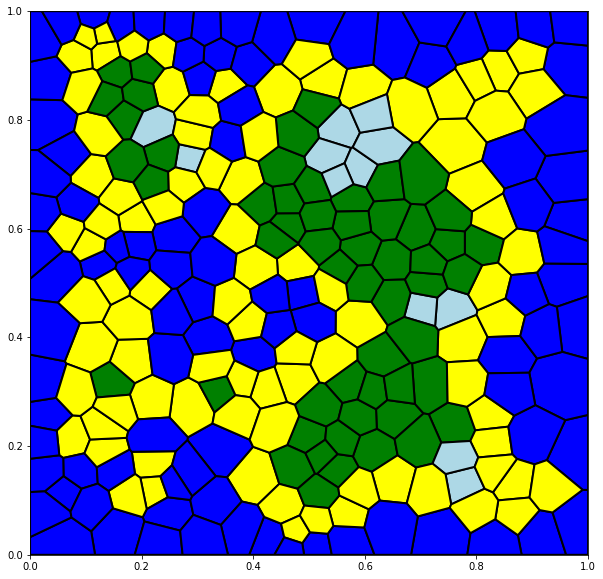

In [19]:
g.plot_full_map()

## 9. Elevation

In [20]:
g.assign_corner_elevations()
g.redistribute_elevations()
g.assign_center_elevations()

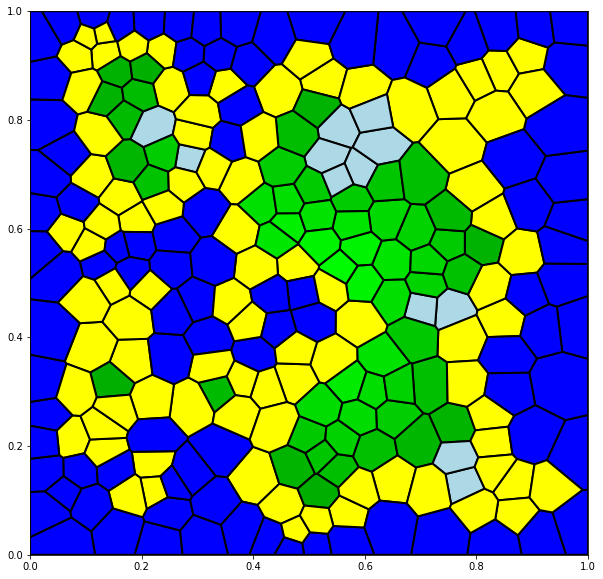

In [21]:
g.plot_full_map(debug_height=False)

In [22]:
g.plot_3d_height_map()

## 10. Rivers

Rivers flow from high elevations down to the coast. <br>
Having elevations that always increase away from the coast means that there’s no local minima that complicate river generation.


In [33]:
g.create_rivers(n=4, min_height=0.5)

For any location, going downhill will eventually lead to the ocean. <br>
This diagram shows the steepest downhill direction from every corner.

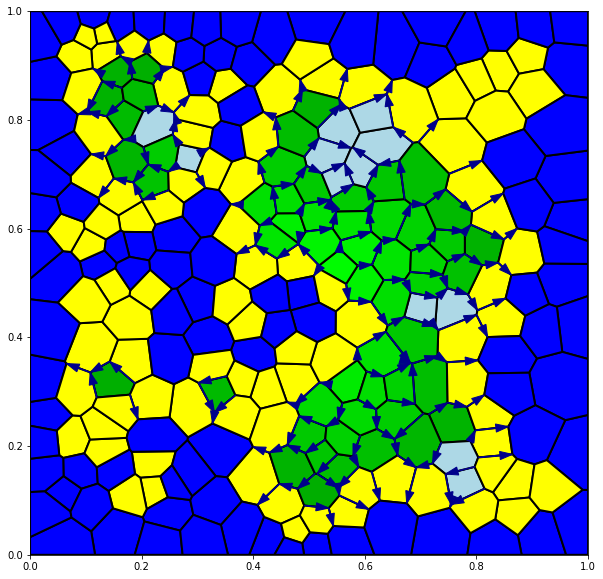

In [35]:
g.plot_full_map(debug_height=False, downslope_arrows=True, rivers=False)

Rivers use the downhill directions shown earlier.

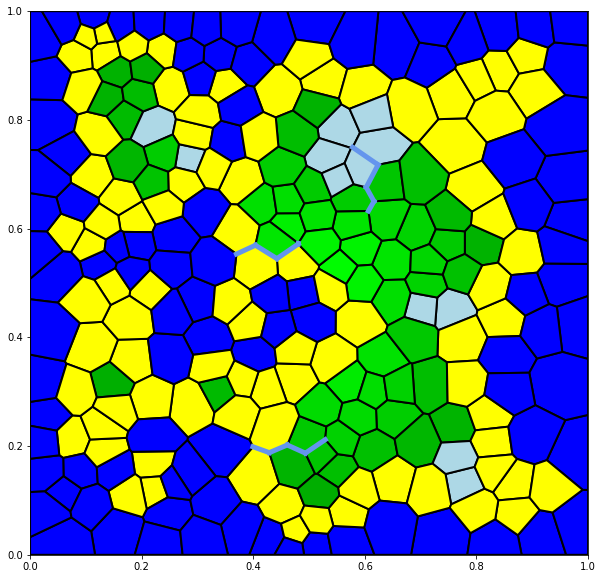

In [36]:
g.plot_full_map(debug_height=False, downslope_arrows=False, rivers=True)